In [4]:
%pip install git+https://github.com/FacePerceiver/facer.git@main

  Cloning https://github.com/FacePerceiver/facer.git (to revision main) to /tmp/pip-req-build-ntfj4g6y
  Running command git clone --filter=blob:none --quiet https://github.com/FacePerceiver/facer.git /tmp/pip-req-build-ntfj4g6y
  Encountered 16 file(s) that should have been pointers, but weren't:
        samples/data/fire.webp
        samples/data/girl.jpg
        samples/data/sideface.jpg
        samples/data/twogirls.jpg
        samples/data/weirdface.jpg
        samples/data/weirdface2.jpg
        samples/data/weirdface3.jpg
        samples/download.ipynb
        samples/example_output/alignment.png
        samples/example_output/detect.png
        samples/example_output/parsing.png
        samples/face_alignment.ipynb
        samples/face_attribute.ipynb
        samples/face_detect.ipynb
        samples/face_parsing.ipynb
        samples/transform.ipynb
  Resolved https://github.com/FacePerceiver/facer.git to commit b2e4fcb94fa8db7cff1a053b6c6441131274c074
  Preparing metadata (se

In [7]:
pwd

'/home/dmarx/projects/whats-in-a-name'

Downloading: "https://github.com/FacePerceiver/facer/releases/download/models-v1/face_parsing.farl.celebm.main_ema_181500_jit.pt" to /home/dmarx/.cache/torch/hub/checkpoints/face_parsing.farl.celebm.main_ema_181500_jit.pt
100%|████████████████████████████████████████| 617M/617M [00:57<00:00, 11.3MB/s]


0.4075748920440674


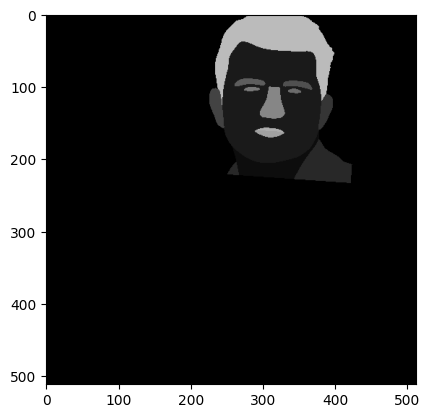

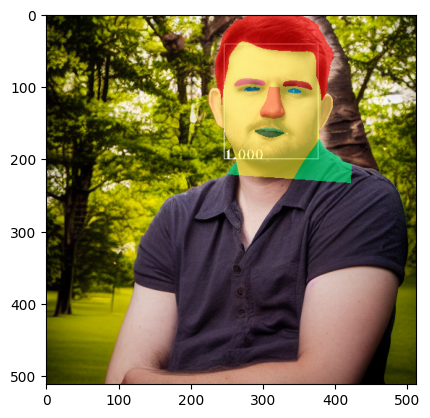

In [23]:
import torch
import facer

import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#image = facer.hwc2bchw(facer.read_hwc('data/twogirls.jpg')).to(device=device)  # image: 1 x 3 x h x w
impath="images/a_photo_of_billy_portrait_photography_full_color_face_full_frame/1695540450_11.png"
image = facer.hwc2bchw(facer.read_hwc(impath)).to(device=device)  # image: 1 x 3 x h x w


face_detector = facer.face_detector('retinaface/mobilenet', device=device)
#face_parser = facer.face_parser('farl/lapa/448', device=device) # optional "farl/celebm/448"
model_id = 'farl/celebm/448'
face_parser = facer.face_parser(model_id, device=device)

st = time.time()
with torch.inference_mode():
    faces = face_detector(image)

with torch.inference_mode():
    faces = face_parser(image, faces)

seg_logits = faces['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w
n_classes = seg_probs.size(1)
vis_seg_probs = seg_probs.argmax(dim=1).float()/n_classes*255
vis_img = vis_seg_probs.sum(0, keepdim=True)

et = time.time()
print(et-st) # .36s for batch_size=1

facer.show_bhw(vis_img)
facer.show_bchw(facer.draw_bchw(image, faces))

In [19]:
faces.keys()

dict_keys(['rects', 'points', 'scores', 'image_ids', 'seg'])

In [20]:
faces['seg'].keys()

dict_keys(['logits', 'label_names'])

In [21]:
faces['seg']['label_names']

['background',
 'face',
 'rb',
 'lb',
 're',
 'le',
 'nose',
 'ulip',
 'imouth',
 'llip',
 'hair']

0


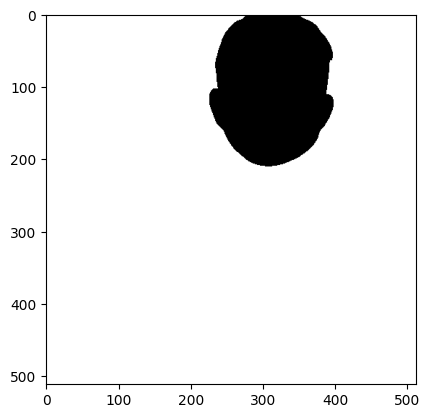

1


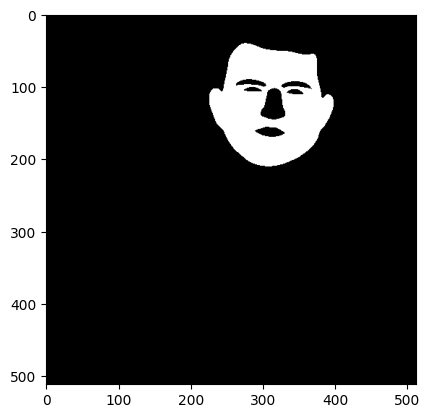

2


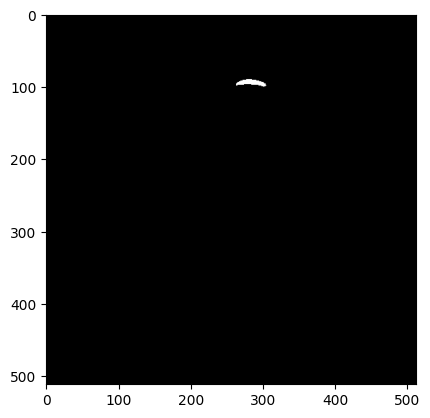

3


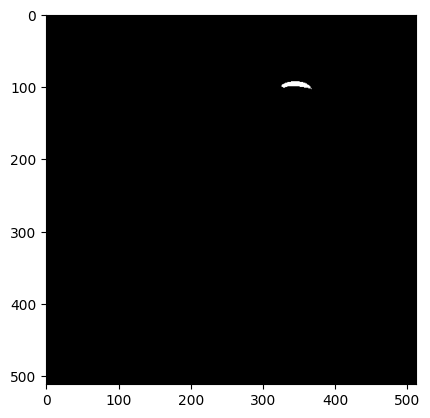

4


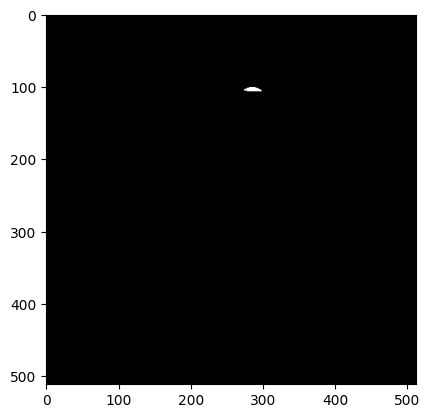

5


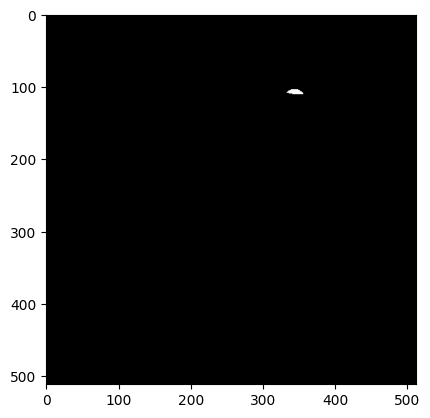

6


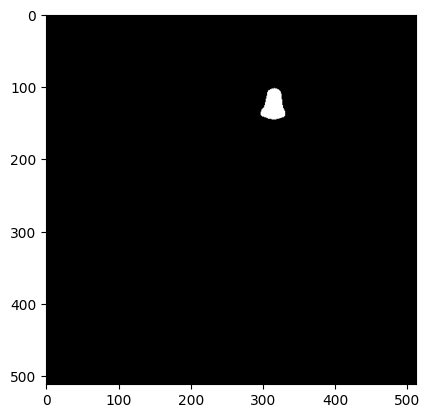

7


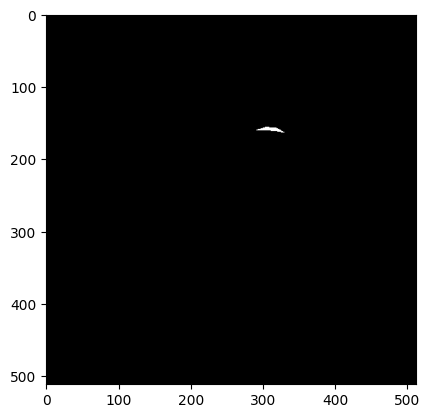

8


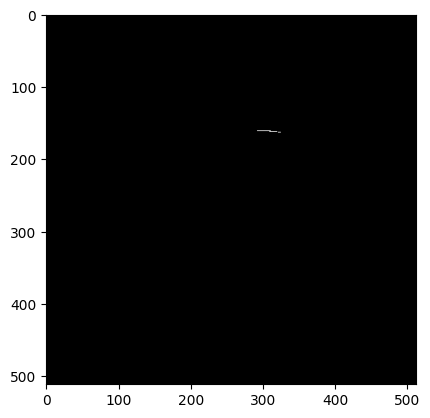

9


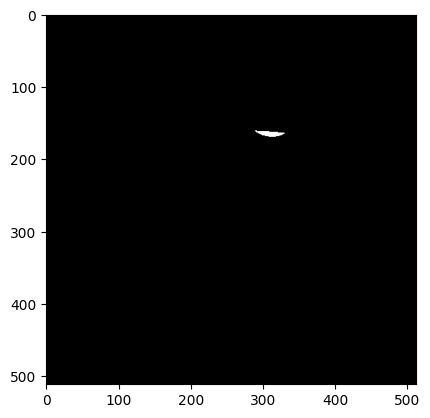

10


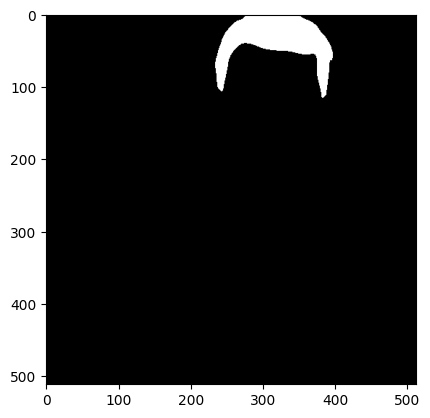

In [15]:
classification = seg_probs.argmax(dim=1)
for class_idx in range(n_classes):
    # vis_seg_probs = seg_probs.argmax(dim=1).float()/n_classes*255
    print(class_idx)
    vis_seg_probs = (classification == class_idx).float()
    vis_seg_probs*=255.
    vis_img = vis_seg_probs.sum(0, keepdim=True)
    facer.show_bhw(vis_img)

# class_idx - notes
# * 0 - head
# * 1 - face skin (sans nose)
# * 6 - nose
# * 2,3 - eyebrows
# * 4,5 - eyes
# * 10 - hair

In [18]:
dir(face_parser)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_sta

In [ ]:
# let's load up LCM through diffusers and see what happens if we pass in a batch of generated images
